In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production hydraulique** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (eau, précipitations).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_D.csv',
                usecols = ['Dates', 'Hydraulique'])
df.head(1)

,Dates,Hydraulique
0,2013-01-01,6805.141667


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_hydraulique_FR.csv',
                  usecols = ['Dates', 'Capa_hyd'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('D').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_hyd'] = df['Hydraulique'] / df['Capa_hyd']
df

,Hydraulique,Capa_hyd,TCH_hyd
Dates,,,
2013-01-01,6805.141667,25346,0.268490
2013-01-02,8782.166667,25346,0.346491
2013-01-03,9143.979167,25346,0.360766
2013-01-04,8631.250000,25346,0.340537
2013-01-05,8025.083333,25346,0.316621
...,...,...,...
2021-10-27,3766.729167,25346,0.148612
2021-10-28,3551.291667,25346,0.140113
2021-10-29,3209.708333,25346,0.126636


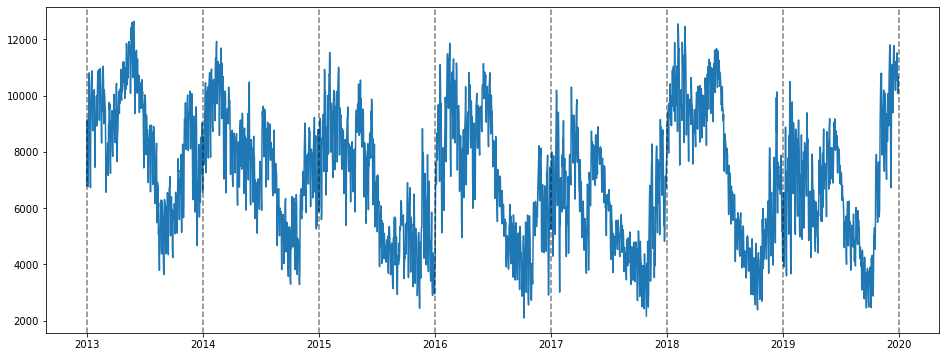

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Hydraulique'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

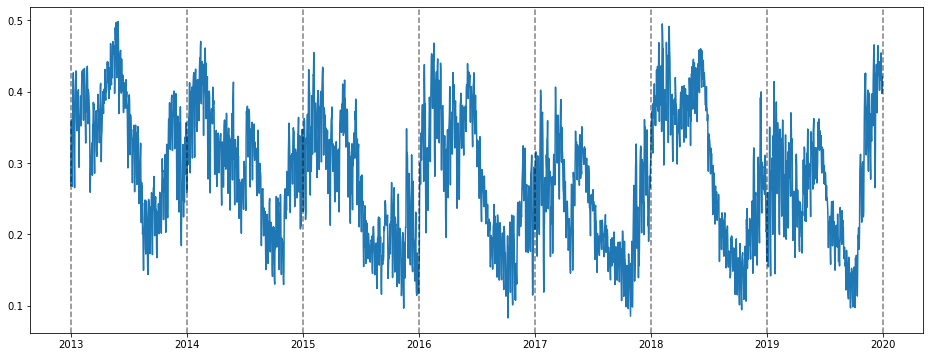

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_hyd'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_hyd'])

(-4.941252477632524,
 2.896865788673183e-05,
 29,
 3196,
 {'1%': -3.432397734657946,
  '5%': -2.862444764925196,
  '10%': -2.567251626693097},
 -13972.122321172363)

### Coéfficients SARIMAX et saisonnalités

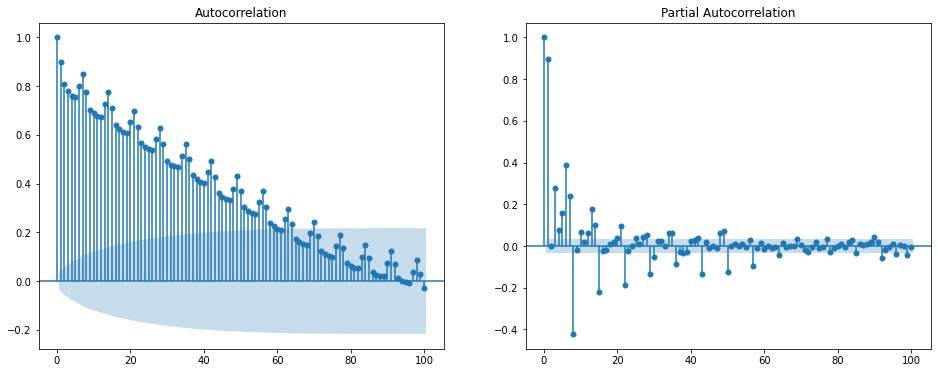

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_hyd'], lags = 100, ax=ax1)
plot_pacf(df['TCH_hyd'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Import du dataset filtré (Transformation de Fourier)

In [12]:
df_filtered = pd.read_csv('./dataset/France_D_filtered.csv',
                usecols = ['Dates', 'Hydraulique'])
df_filtered.head(1)

,Dates,Hydraulique
0,2013-01-01,6348.37141


In [13]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [14]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_hyd'] = df_filtered['Hydraulique'] / df_filtered['Capa_hyd']

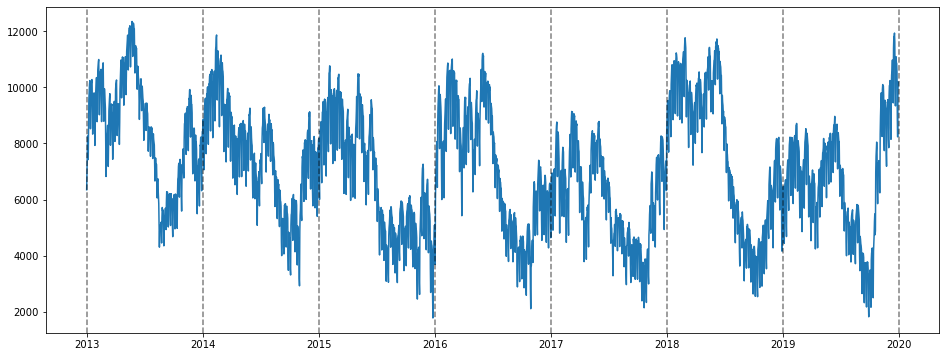

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Hydraulique'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

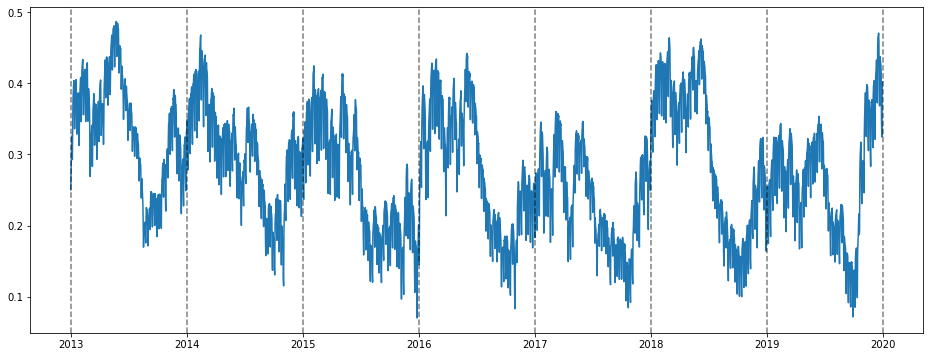

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_hyd'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [17]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [18]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [19]:
fenetre = df_test.shape[0]

In [20]:
indice = df_test.index

In [21]:
bilan = df_test

# Paramètres SARIMAX

In [22]:
ordre = (2,0,0)
saison = (0,0,0,365)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [23]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [24]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-25-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

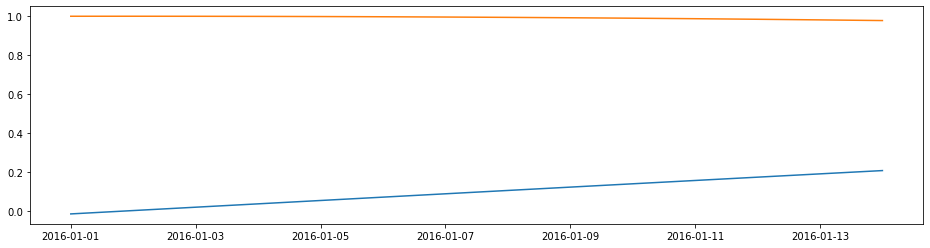

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [26]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [27]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [28]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Hyd_p_sinus'], index = indice)

In [29]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [30]:
bilan['Err_sinus'] = np.abs(bilan['Hyd_p_sinus'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus
count,670.000000,670.0,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298
std,2126.241737,0.0,0.083889,0.077289,0.045091
min,2714.229167,25346.0,0.107087,0.128987,0.000027
25%,5620.468750,25346.0,0.221750,0.259692,0.031337
50%,7204.583333,25346.0,0.284249,0.329364,0.055099
75%,8798.942708,25346.0,0.347153,0.376340,0.091653
max,13298.458333,25346.0,0.524677,0.493240,0.233056


# Régresseurs exogènes : données métier

In [31]:
exog = pd.read_csv('./exog/exog_D_FR.csv', sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01,1.806651


In [32]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [33]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [34]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [35]:
result_exog = model_exog.fit(low_memory=True)

In [36]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                4716.634
Date:                Wed, 04 May 2022   AIC                          -9425.268
Time:                        10:27:35   BIC                          -9401.884
Sample:                             0   HQIC                         -9416.788
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -7.957e-05      0.001     -0.151      0.880      -0.001       0.001
ar.L1          0.9561      0.020     48.334      0.000       0.917       0.995
ar.L2          0.0361      0.020      1.825      0.068      -0.003       0.075
sigma2         0.0015   4.08e-05     35.757      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                84.56
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.26
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [37]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [38]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Hyd_p_exog'])

In [39]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_exog'] = np.abs(bilan['Hyd_p_exog'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388


# Régresseurs exogènes : données métier FILTREES

In [41]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01,2.766248


In [42]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [43]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [44]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [45]:
result_filter = model_filter.fit(low_memory=True)

In [46]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                4716.829
Date:                Wed, 04 May 2022   AIC                          -9425.658
Time:                        10:27:39   BIC                          -9402.273
Sample:                             0   HQIC                         -9417.178
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0004      0.001     -0.649      0.517      -0.001       0.001
ar.L1          0.9559      0.020     48.332      0.000       0.917       0.995
ar.L2          0.0363      0.020      1.835      0.066      -0.002       0.075
sigma2         0.0015   4.08e-05     35.758      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):                85.17
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.26
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [47]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [48]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Hyd_p_filter'])

In [49]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [50]:
bilan['Err_exog_filter'] = np.abs(bilan['Hyd_p_filter'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528,0.320028,0.065533
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100,0.076987,0.045108
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239,0.129645,0.000138
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747,0.259357,0.031381
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730,0.330138,0.055751
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729,0.377154,0.091664
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388,0.494471,0.232703


# Target FILTREE sans régresseur

### SARIMAX

In [51]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_hyd'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [52]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

In [53]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5347.844
Date:                Wed, 04 May 2022   AIC                         -10689.688
Time:                        10:27:39   BIC                         -10672.149
Sample:                             0   HQIC                        -10683.327
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0545      0.020     53.422      0.000       1.016       1.093
ar.L2         -0.0597      0.020     -3.024      0.002      -0.098      -0.021
sigma2         0.0009   2.49e-05     35.749      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):               166.03
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.59
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [54]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [55]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Hyd_p_reduit_noreg'])

In [56]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [57]:
bilan['Err_filter_noreg'] = np.abs(bilan['Hyd_p_reduit_noreg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528,0.320028,0.065533,0.319717,0.063185
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100,0.076987,0.045108,0.075358,0.044097
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239,0.129645,0.000138,0.122704,0.000255
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747,0.259357,0.031381,0.264728,0.028815
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730,0.330138,0.055751,0.327012,0.055479
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729,0.377154,0.091664,0.372683,0.089390
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388,0.494471,0.232703,0.484728,0.224707


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [58]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01,2.766248


In [59]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [60]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [61]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [62]:
result_reduit = model_reduit.fit(low_memory=True)

In [63]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5348.302
Date:                Wed, 04 May 2022   AIC                         -10688.604
Time:                        10:27:44   BIC                         -10665.219
Sample:                             0   HQIC                        -10680.123
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0004      0.000     -0.967      0.333      -0.001       0.000
ar.L1          1.0540      0.020     53.383      0.000       1.015       1.093
ar.L2         -0.0593      0.020     -3.001      0.003      -0.098      -0.021
sigma2         0.0009   2.49e-05     35.761      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   1.30   Jarque-Bera (JB):               164.59
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.58
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [64]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [65]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Hyd_p_reduit'])

In [66]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [67]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Hyd_p_reduit'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528,0.320028,0.065533,0.319717,0.063185,0.319694,0.063163
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100,0.076987,0.045108,0.075358,0.044097,0.075358,0.044100
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239,0.129645,0.000138,0.122704,0.000255,0.122491,0.000137
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747,0.259357,0.031381,0.264728,0.028815,0.264670,0.028961
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730,0.330138,0.055751,0.327012,0.055479,0.327028,0.055360
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729,0.377154,0.091664,0.372683,0.089390,0.372650,0.089236
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388,0.494471,0.232703,0.484728,0.224707,0.484696,0.225013


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [68]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01,2.766248


In [69]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [70]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [71]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_hyd'])
predict_lr = LinReg.predict(exog_test)

In [72]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Hyd_p_LinReg'])

In [73]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [74]:
bilan['Err_LinReg'] = np.abs(bilan['Hyd_p_LinReg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528,0.320028,0.065533,0.319717,0.063185,0.319694,0.063163,0.284989,0.069091
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100,0.076987,0.045108,0.075358,0.044097,0.075358,0.044100,0.006848,0.047843
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239,0.129645,0.000138,0.122704,0.000255,0.122491,0.000137,0.275498,0.000058
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747,0.259357,0.031381,0.264728,0.028815,0.264670,0.028961,0.280772,0.030680
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730,0.330138,0.055751,0.327012,0.055479,0.327028,0.055360,0.282895,0.060539
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729,0.377154,0.091664,0.372683,0.089390,0.372650,0.089236,0.286969,0.103919
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388,0.494471,0.232703,0.484728,0.224707,0.484696,0.225013,0.328408,0.241174


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [75]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-01,2.766248


In [76]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [77]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [78]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_hyd'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [79]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Hyd_p_LinReg_filter'])

In [80]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [81]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Hyd_p_LinReg_filter'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg,Hyd_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,0.319838,0.065298,0.320023,0.065528,0.320028,0.065533,0.319717,0.063185,0.319694,0.063163,0.284989,0.069091,0.284777,0.069091
std,2126.241737,0.0,0.083889,0.077289,0.045091,0.076971,0.045100,0.076987,0.045108,0.075358,0.044097,0.075358,0.044100,0.006848,0.047843,0.006588,0.047819
min,2714.229167,25346.0,0.107087,0.128987,0.000027,0.129480,0.000239,0.129645,0.000138,0.122704,0.000255,0.122491,0.000137,0.275498,0.000058,0.275648,0.000009
25%,5620.468750,25346.0,0.221750,0.259692,0.031337,0.259386,0.031747,0.259357,0.031381,0.264728,0.028815,0.264670,0.028961,0.280772,0.030680,0.280721,0.030567
50%,7204.583333,25346.0,0.284249,0.329364,0.055099,0.330329,0.055730,0.330138,0.055751,0.327012,0.055479,0.327028,0.055360,0.282895,0.060539,0.282763,0.060522
75%,8798.942708,25346.0,0.347153,0.376340,0.091653,0.377015,0.091729,0.377154,0.091664,0.372683,0.089390,0.372650,0.089236,0.286969,0.103919,0.286682,0.103433
max,13298.458333,25346.0,0.524677,0.493240,0.233056,0.494307,0.232388,0.494471,0.232703,0.484728,0.224707,0.484696,0.225013,0.328408,0.241174,0.326544,0.241330


# Calcul de la prediction : TCH x Capacité

In [82]:
bilan['Hyd_p_sinus'] = bilan['Hyd_p_sinus'] * bilan['Capa_hyd']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_hyd']
bilan['Hyd_p_exog'] = bilan['Hyd_p_exog'] * bilan['Capa_hyd']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_hyd']
bilan['Hyd_p_filter'] = bilan['Hyd_p_filter'] * bilan['Capa_hyd']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_hyd']
bilan['Hyd_p_reduit_noreg'] = bilan['Hyd_p_reduit_noreg'] * bilan['Capa_hyd']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_hyd']
bilan['Hyd_p_reduit'] = bilan['Hyd_p_reduit'] * bilan['Capa_hyd']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_hyd']
bilan['Hyd_p_LinReg'] = bilan['Hyd_p_LinReg'] * bilan['Capa_hyd']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_hyd']
bilan['Hyd_p_LinReg_filter'] = bilan['Hyd_p_LinReg_filter'] * bilan['Capa_hyd']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_hyd']
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_sinus,Err_sinus,Hyd_p_exog,Err_exog,Hyd_p_filter,Err_exog_filter,Hyd_p_reduit_noreg,Err_filter_noreg,Hyd_p_reduit,Err_filter_exog_filter,Hyd_p_LinReg,Err_LinReg,Hyd_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.0,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,7260.388184,25346.0,0.286451,8106.609350,1655.032904,8111.307161,1660.875876,8111.422426,1661.008148,8103.556877,1601.494203,8102.975190,1600.938963,7223.332574,1751.180133,7217.967650,1751.187975
std,2126.241737,0.0,0.083889,1958.954373,1142.864589,1950.915471,1143.114734,1951.324990,1143.302134,1910.034570,1117.693489,1910.020234,1117.768984,173.581613,1212.625847,166.975055,1212.031160
min,2714.229167,25346.0,0.107087,3269.293272,0.679022,3281.788475,6.045886,3285.988828,3.505697,3110.065795,6.459041,3104.664392,3.480564,6982.770900,1.457546,6986.561810,0.225915
25%,5620.468750,25346.0,0.221750,6582.148165,794.256185,6574.398842,804.667749,6573.660100,795.395087,6709.790666,730.355195,6708.332071,734.057254,7116.450116,777.607197,7115.153163,774.763309
50%,7204.583333,25346.0,0.284249,8348.066669,1396.533454,8372.522224,1412.532601,8367.687454,1413.072833,8288.437812,1406.172581,8288.843084,1403.148631,7170.267488,1534.417732,7166.922233,1533.979997
75%,8798.942708,25346.0,0.347153,9538.718549,2323.040497,9555.814977,2324.964459,9559.345828,2323.317706,9446.019577,2265.686965,9445.186256,2261.773669,7273.507372,2633.929830,7266.232782,2621.624633
max,13298.458333,25346.0,0.524677,12501.657836,5907.049961,12528.695038,5890.111179,12532.853526,5898.087530,12285.925152,5695.413204,12285.101989,5703.191130,8323.826650,6112.808235,8276.576656,6116.738956


# Visualisation réel vs prédictions

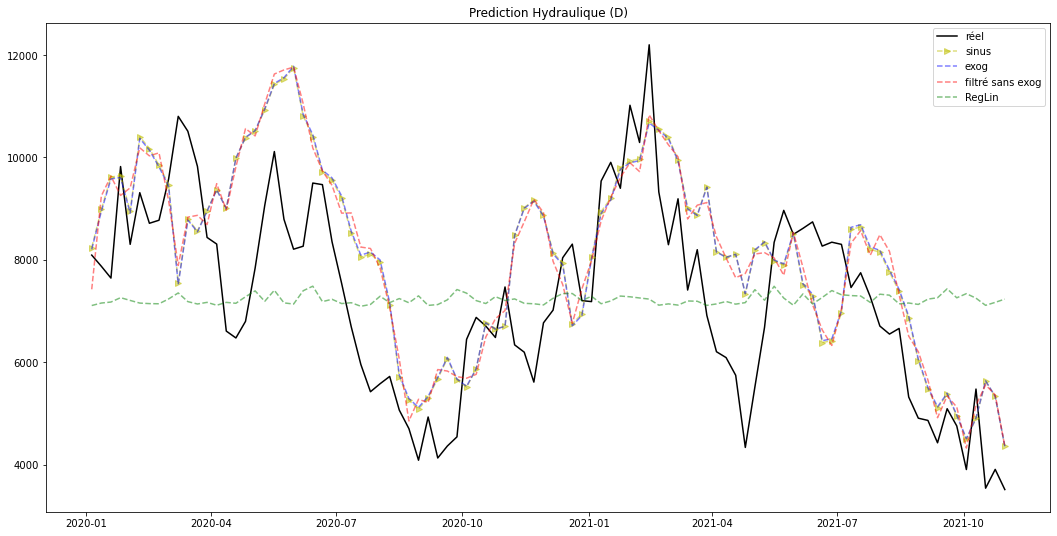

In [83]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Hydraulique'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Hyd_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Hyd_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
#plt.plot(bilan['Hyd_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Hyd_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
#plt.plot(bilan['Hyd_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Hyd_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
#plt.plot(bilan['Hyd_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Hydraulique (D)')
plt.savefig('./results/pred_hydraulique_D.png');

# Synthèse des erreurs

In [85]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1655.032904,1660.875876,1661.008148,1601.494203,1600.938963,1751.180133,1751.187975
std,1142.864589,1143.114734,1143.302134,1117.693489,1117.768984,1212.625847,1212.031160
min,0.679022,6.045886,3.505697,6.459041,3.480564,1.457546,0.225915
25%,794.256185,804.667749,795.395087,730.355195,734.057254,777.607197,774.763309
50%,1396.533454,1412.532601,1413.072833,1406.172581,1403.148631,1534.417732,1533.979997
75%,2323.040497,2324.964459,2323.317706,2265.686965,2261.773669,2633.929830,2621.624633
max,5907.049961,5890.111179,5898.087530,5695.413204,5703.191130,6112.808235,6116.738956


In [86]:
bilan.to_csv('./results/bilan_hydraulique_D.csv', sep = ';')
erreur.to_csv('./results/erreur_hydraulique_D.csv', sep = ';')